In [1]:
import re
from pdfminer.high_level import extract_text

def get_atvs(directory, filename, separator):
    # Carregando o texto do arquivo PDF utf 8
    texto = extract_text(f'{directory}/{filename}', codec='utf-8')
    # Expressão regular para capturar o texto entre "Atividades:" e o padrão especificado "LETRA,LETRA,LETRA,NUMERO,NUMERO,PONTO,NUMERO,NUMERO"
    padrao = re.compile(r'Atividades:(.*?)(?=\b[A-Z]{3}\d{2}\.\d{2}\b|$)', re.DOTALL)
    # Encontrar todas as correspondências
    atividades = padrao.findall(texto)

    if separator == 'paragraph':
        return [clean_atvs(text) for text in atividades]

    elif separator == 'phrase':
        # Processar cada conjunto de atividades para separá-las corretamente
        atividades_separadas = [re.split(r'\n\d+\.\s*', ativ.strip()) for ativ in atividades]
        # Achatando a lista de listas em uma única lista e filtrando entradas vazias
        atividades_finais = [item for sublist in atividades_separadas for item in sublist if item]

        return [clean_atvs(text) for text in atividades_finais]
        

In [2]:
import unidecode
import re

def clean_atvs(texto):
    # Normaliza o texto removendo acentos e convertendo para minúsculas
    texto_limpo = unidecode.unidecode(texto).lower()

    # Remove números seguidos por pontos, e caracteres não-alfabéticos exceto espaços
    texto_limpo = re.sub(r'\d+\.', '', texto_limpo)
    texto_limpo = re.sub(r'[^a-z\s]', '', texto_limpo)

    # Remove múltiplos espaços e a palavra 'atividade'
    texto_limpo = re.sub(r'\s+', ' ', texto_limpo)
    texto_limpo = re.sub(r'\batividade\b', '', texto_limpo)

    # Remove espaços extras no início e no final
    texto_limpo = texto_limpo.strip()
    

    return None if texto_limpo == '' else texto_limpo


##### Define Corpus

In [3]:

import os
directory_list = os.listdir('Corpus')

corpus = {}
for directory in directory_list:
    file_list = os.listdir(f'Corpus/{directory}')
    for file in file_list:
        atvs = get_atvs(f'Corpus/{directory}', file, separator='paragraph')
        atvs = [atv for atv in atvs if atv]
        corpus[directory] = corpus.get(directory, []) + atvs

##### Verifica balanceamento

In [4]:
# Verificar o balanceamento
for key, value in corpus.items():
    print(f'{key}: {len(value)}')

APO: 71
BAI: 67
DSS: 37
EDM: 15
MEA: 17


In [5]:
from sklearn.utils import resample

# Função para balancear os dados
def balance_data(corpus):
    max_size = max(len(value) for value in corpus.values())
    balanced_corpus = {key: resample(value, replace=True, n_samples=max_size, random_state=42) for key, value in corpus.items()}
    return balanced_corpus

# Balancear o corpus
balanced_corpus = balance_data(corpus)

In [6]:
# Verificar o balanceamento
for key, value in balanced_corpus.items():
    print(f'{key}: {len(value)}')


APO: 71
BAI: 71
DSS: 71
EDM: 71
MEA: 71


In [7]:
#Save corpus to json
import json
with open('corpus.json', 'w', encoding='utf-8') as f:
    json.dump(corpus, f, ensure_ascii=False, indent=4)

##### Define Alvos

In [16]:
import os
alvos_files = os.listdir('Alvo')


In [17]:
from pdfminer.high_level import extract_text


alvos_data_raw = []
[alvos_data_raw.append(extract_text(f'Alvo/{file}', codec='utf-8')) for file in alvos_files]
alvos_data = [clean_atvs(texto) for texto in alvos_data_raw]

In [18]:
alvos_data

['estabelecer uma estrutura organizacional interna e estendida que reflita necessidades de negocios e prioridades de ti colocar em pratica as estruturas de gestao necessarias por exemplo comites que permitam que a tomada de decisoes de gestao ocorra da forma mais eficaz e eficiente definir o escopo as funcoes internas e externas os papeis internos e externos as capacidades e os direitos de decisao necessarios incluindo as atividades de ti realizadas por terceiros definir o escopo as funcoes internas e externas os papeis internos e externos as capacidades e os direitos de decisao necessarios incluindo as atividades de ti realizadas por terceiros identificar as decisoes necessarias para o alcance dos resultados da empresa e da estrategia de ti bem como para a gestao e execucao dos servicos de ti estabelecer o envolvimento das partes interessadas que sao fundamentais para a tomada de decisoes aprovador responsavel consultado ou informado alinhar a organizacao relacionada a ti com modelos 

## TF IDF with SVM

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


atividades = []
labels = []

for label,atvs in balanced_corpus.items():
    if atvs != None:
        atividades.extend(atvs)
        labels.extend([label]*len(atvs))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(atividades, labels, test_size=0.2, random_state=10, shuffle=True)

vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Treinando o modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = svm_model.predict(X_test)

# Avaliando o modelo
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.971830985915493


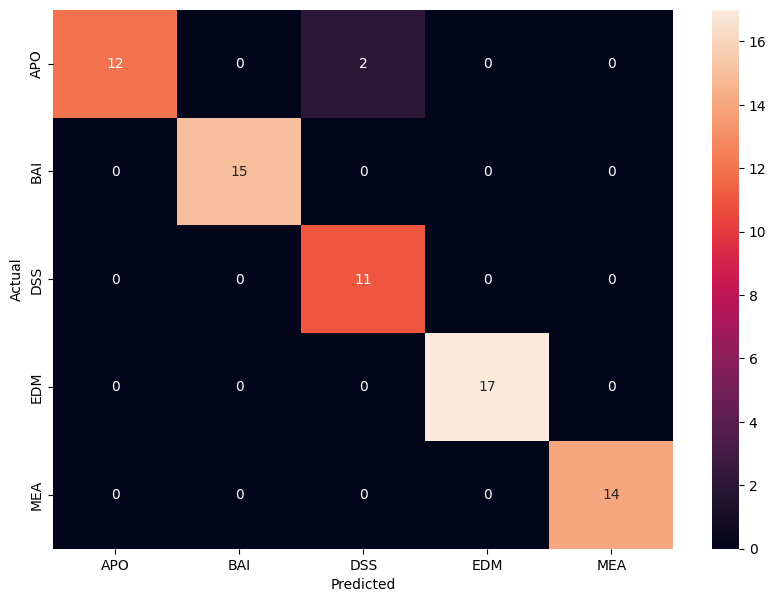

In [34]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=corpus.keys(), yticklabels=corpus.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
#predict text
svm_model.predict(vectorizer.transform(alvos_data))

array(['APO', 'APO', 'DSS'], dtype='<U3')

## Bertimbau

In [8]:
import optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

c:\Users\diego\miniconda3\envs\prodemge_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def objective(trial):
    # Definir hiperparâmetros para a otimização
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_epochs', 2, 6)
    
    sentences = [sentence for sentence_group in balanced_corpus.values() for sentence in sentence_group]
    labels_dict = {label: i for i, label in enumerate(balanced_corpus.keys())}
    labels = [label for label in balanced_corpus.keys() for _ in range(len(balanced_corpus[label]))]
    labels = [labels_dict[label] for label in labels]

    model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=len(labels_dict))
    tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

    train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

    max_length = 512
    train_inputs = tokenizer(train_sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    test_inputs = tokenizer(test_sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(train_labels))
    test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(test_labels))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.train()
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia: ", study.best_value)

[I 2024-08-03 17:00:11,201] A new study created in memory with name: no-name-cb361e34-0e94-4950-9e25-d257465ab00f
C:\Users\diego\AppData\Local\Temp\ipykernel_11448\2833674752.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\diego\miniconda3\envs\prodemge_env\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pyto

In [40]:
# Definir hiperparâmetros para a otimização
learning_rate = 0.00011192968014092933
batch_size = 8
num_epochs = 2

sentences = [sentence for sentence_group in balanced_corpus.values() for sentence in sentence_group]
labels_dict = {label: i for i, label in enumerate(balanced_corpus.keys())}
labels = [label for label in balanced_corpus.keys() for _ in range(len(balanced_corpus[label]))]
labels = [labels_dict[label] for label in labels]

model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=len(labels_dict))
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

max_length = 512
train_inputs = tokenizer(train_sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
test_inputs = tokenizer(test_sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(train_labels))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(test_labels))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f'Epoch: {epoch + 1}, Loss: {loss}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1, Loss: 1.6341867446899414
Epoch: 1, Loss: 1.7509791851043701
Epoch: 1, Loss: 1.7385274171829224
Epoch: 1, Loss: 1.584486722946167
Epoch: 1, Loss: 1.6345984935760498
Epoch: 1, Loss: 1.500366449356079
Epoch: 1, Loss: 1.637732744216919
Epoch: 1, Loss: 1.532938838005066
Epoch: 1, Loss: 1.7306888103485107
Epoch: 1, Loss: 1.4345636367797852
Epoch: 1, Loss: 1.6680219173431396
Epoch: 1, Loss: 1.6887059211730957
Epoch: 1, Loss: 1.4596357345581055
Epoch: 1, Loss: 1.4798845052719116
Epoch: 1, Loss: 1.3508882522583008
Epoch: 1, Loss: 1.3904569149017334
Epoch: 1, Loss: 1.2457129955291748
Epoch: 1, Loss: 1.2197612524032593
Epoch: 1, Loss: 1.4608525037765503
Epoch: 1, Loss: 1.149946689605713
Epoch: 1, Loss: 1.1437511444091797
Epoch: 1, Loss: 1.3481992483139038
Epoch: 1, Loss: 1.2218270301818848
Epoch: 1, Loss: 1.0828537940979004
Epoch: 1, Loss: 0.9670946002006531
Epoch: 1, Loss: 1.1129915714263916
Epoch: 1, Loss: 0.8250787258148193
Epoch: 1, Loss: 0.6683709025382996
Epoch: 1, Loss: 1.1223367

Accuracy: 0.8732394366197183


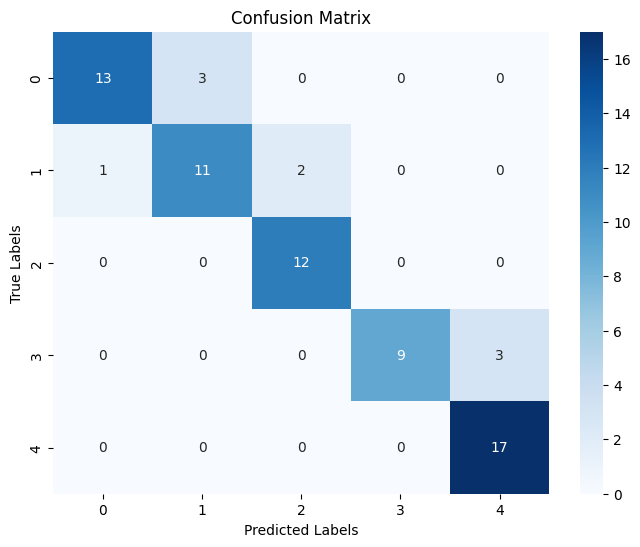

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Armazenar todas as previsões e rótulos verdadeiros
all_predictions = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        all_predictions.extend(predicted.tolist())
        all_true_labels.extend(labels.tolist())

accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()


In [38]:
def predict_text(text, model, tokenizer, device):
    # Preparar o texto para o modelo
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Mover para o dispositivo apropriado (GPU ou CPU)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Avaliar o modelo
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Obter a maior pontuação de logits (índice do valor máximo)
    _, predicted_index = torch.max(outputs.logits, 1)
    
    # Converter o índice previsto em etiqueta de classe
    predicted_label = list(labels_dict.keys())[predicted_index.item()]
    
    return predicted_label

In [19]:
for alvo in alvos_data:
    print(predict_text(alvo, model, tokenizer, device))

EDM
BAI
APO
